<a href="https://colab.research.google.com/github/ganzagun/Data_Analysis/blob/main/BloodCell_Analysis/BloodCell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Data Analysis





In [2]:
from IPython.display import HTML
from subprocess import getoutput
s = getoutput('nvidia-smi')
if 'K80' in s:
    gpu = 'K80'
elif 'T4' in s:
    gpu = 'T4'
elif 'P100' in s:
    gpu = 'P100'
else:
    gpu='DONT PROCEED'
display(HTML(f"<h1>{gpu}</h1>"))

In [3]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
import sklearn
import itertools
import cv2
import scipy
import os
import csv
from PIL import Image
import cv2
import os , glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Setting Required Variable

In [4]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/Data_folder/Blood cell/

/content/drive/MyDrive/Data_folder/Blood cell


In [7]:
path_images = "dataset-master/JPEGImages/"
label_path = "dataset-master/labels.csv"
annot_path = "dataset-master/Annotations/"

## Loading Data

In [8]:
label = pd.read_csv(label_path)
label.head(5)

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL


In [9]:
def load_images(path_images,label_path):
    images = os.listdir(path_images)
    label = pd.read_csv(label_path)
    path = []
    images_df = pd.DataFrame(columns={"Image_name","Image","Label"})
    print(len(images))
    
    #masks2 = sorted_alphanum(masks)
    
    count =0
    for i in images:
        im = Image.open(path_images + i)
        im1 = np.array(im.resize((256,256)))/255
        temp ={"Image_name":i,"Image":im1,"Label":label[label["Image"]==int(i[-9:-4])]["Category"].values[0]}
        images_df = images_df.append(temp,ignore_index=True)
        del im,im1
        count+=1
        if(count%20==0):
          print(count)
    
    #data = pd.DataFrame({"Image_Name":path,"Image":images_list,"Labels":label})
    return images_df

In [10]:
image_data= load_images(path_images,label_path)

366
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360


In [11]:
image_data.shape

(366, 3)

In [12]:
image_data["Image"][0].shape

(256, 256, 3)

In [13]:
image_data["Label"][100],image_data["Image_name"][100]

('EOSINOPHIL', 'BloodImage_00219.jpg')

In [14]:
image_data.head(5)

,Label,Image_name,Image
0,NEUTROPHIL,BloodImage_00393.jpg,"[[[0.7098039215686275, 0.7294117647058823, 0.7..."
1,NEUTROPHIL,BloodImage_00012.jpg,"[[[0.7098039215686275, 0.7411764705882353, 0.6..."
2,NEUTROPHIL,BloodImage_00340.jpg,"[[[0.6666666666666666, 0.6313725490196078, 0.6..."
3,NEUTROPHIL,BloodImage_00250.jpg,"[[[0.7019607843137254, 0.6705882352941176, 0.6..."
4,NEUTROPHIL,BloodImage_00366.jpg,"[[[0.6588235294117647, 0.5411764705882353, 0.5..."


## Lets start the analysis
 Lets see all the four images . Here each image contains a single kind of cell and each image can have upto 10 cells 

In [15]:
neutrophil_img = image_data[image_data["Label"]==dict_characters[1]]["Image"].values[1]
esonophil_img = image_data[image_data["Label"]==dict_characters[2]]["Image"].values[1]
monocyte_img = image_data[image_data["Label"]==dict_characters[3]]["Image"].values[0]
lymphocyte_img = image_data[image_data["Label"]==dict_characters[4]]["Image"].values[0]

Text(0.5, 1.0, 'LYMPHOCYTE')

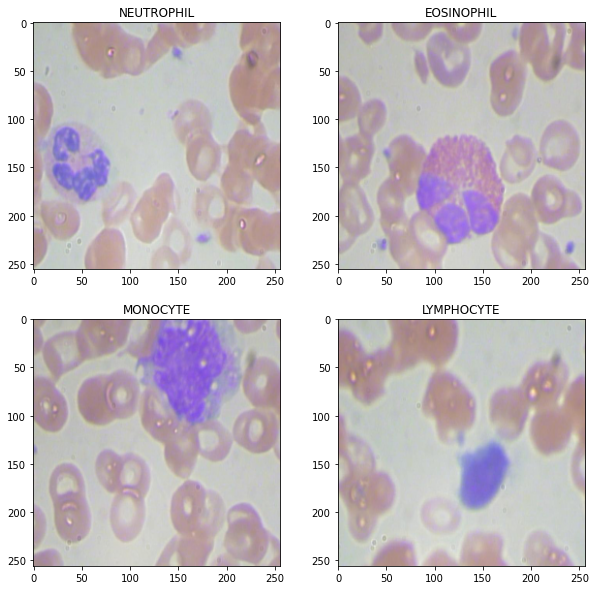

In [16]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].imshow(neutrophil_img)
ax[0][0].set_title('NEUTROPHIL')
ax[0][1].imshow(esonophil_img)
ax[0][1].set_title('EOSINOPHIL')
ax[1][0].imshow(monocyte_img)
ax[1][0].set_title('MONOCYTE')
ax[1][1].imshow(lymphocyte_img)
ax[1][1].set_title('LYMPHOCYTE')

For any image specific classification, clustering, etc.We have to collapse spatial dimensions so that we have a matrix of pixels by color channels.

In [17]:
dims = neutrophil_img.shape
dims

(256, 256, 3)

In [18]:
neutrophil_matrix = np.reshape(neutrophil_img, (dims[0] * dims[1], dims[2]))
esonophil_matrix = np.reshape(esonophil_img, (dims[0] * dims[1], dims[2]))
monocyte_matrix = np.reshape(monocyte_img, (dims[0] * dims[1], dims[2]))
lymphocyte_matrix = np.reshape(lymphocyte_img, (dims[0] * dims[1], dims[2]))
print(np.shape(neutrophil_matrix))

(65536, 3)



Scatter plots are a go to to look for clusters and separatbility in the data, but they don't reveal density well, so lets use 2d histograms instead. The data between bands is really correlated. 

1.Like For Neutrophil the correlation between G and B channel seems to have less variance than Monocyte.

2 While in case of Eosinophil and Lymphocyte . Eosinophil seems to have a higher variance and is more scattered

3 While mean of all cells are almost same 

Text(0.5, 1.0, 'LYMPHOCYTE')

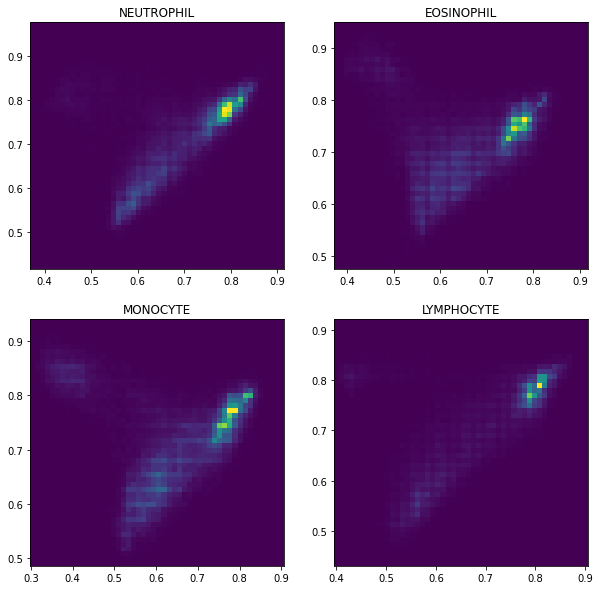

In [19]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].hist2d(neutrophil_matrix[:,1],neutrophil_matrix[:,2], bins=(50,50))
ax[0][0].set_title('NEUTROPHIL')
ax[0][1].hist2d(esonophil_matrix[:,1], esonophil_matrix[:,2], bins=(50,50))
ax[0][1].set_title('EOSINOPHIL')
ax[1][0].hist2d(monocyte_matrix[:,1], monocyte_matrix[:,2], bins=(50,50))
ax[1][0].set_title('MONOCYTE')
ax[1][1].hist2d(lymphocyte_matrix[:,1], lymphocyte_matrix[:,2], bins=(50,50))
ax[1][1].set_title('LYMPHOCYTE')

Text(0.5, 1.0, 'LYMPHOCYTE')

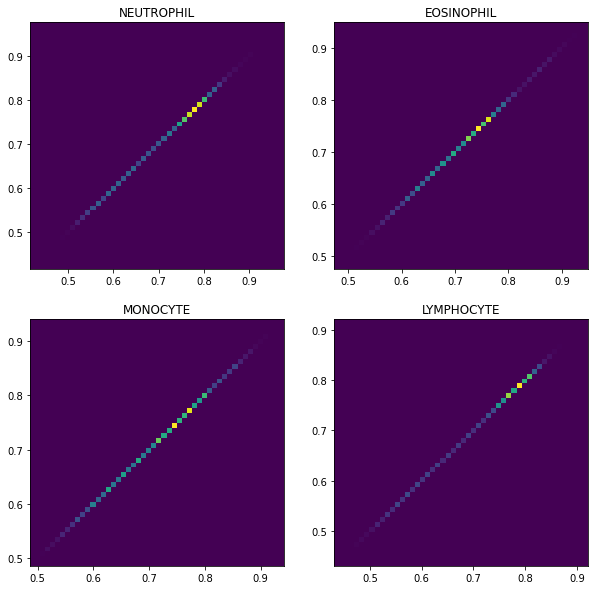

In [20]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].hist2d(neutrophil_matrix[:,2],neutrophil_matrix[:,2], bins=(50,50))
ax[0][0].set_title('NEUTROPHIL')
ax[0][1].hist2d(esonophil_matrix[:,2], esonophil_matrix[:,2], bins=(50,50))
ax[0][1].set_title('EOSINOPHIL')
ax[1][0].hist2d(monocyte_matrix[:,2], monocyte_matrix[:,2], bins=(50,50))
ax[1][0].set_title('MONOCYTE')
ax[1][1].hist2d(lymphocyte_matrix[:,2], lymphocyte_matrix[:,2], bins=(50,50))
ax[1][1].set_title('LYMPHOCYTE')

 Lets take a quick look at color value histograms for pixel matrix of images

 Observation :- 
 1 Eosinophil seems to have higher density of blue while low for red

 2 For monoctyte density of all are almost same and are spread the most

 3 For lymphocyte the spread is not too much similar to seen in histogram

Text(0.5, 1.0, 'LYMPHOCYTE')

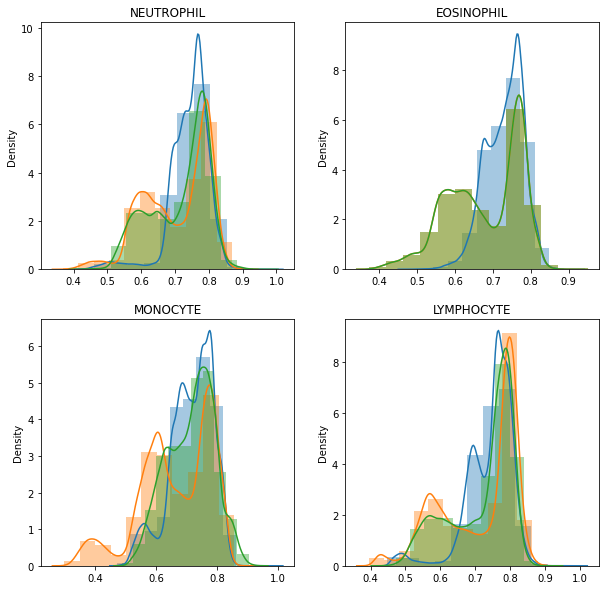

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

sns.distplot(neutrophil_matrix[:,0], bins=12,ax=ax[0][0])
sns.distplot(neutrophil_matrix[:,1], bins=12,ax=ax[0][0])
sns.distplot(neutrophil_matrix[:,2], bins=12,ax=ax[0][0])
ax[0][0].set_title('NEUTROPHIL')

sns.distplot(esonophil_matrix[:,0], bins=12,ax=ax[0][1])
sns.distplot(esonophil_matrix[:,1], bins=12,ax=ax[0][1])
sns.distplot(esonophil_matrix[:,1], bins=12,ax=ax[0][1])
ax[0][1].set_title('EOSINOPHIL')

sns.distplot(monocyte_matrix[:,0], bins=12,ax=ax[1][0])
sns.distplot(monocyte_matrix[:,1], bins=12,ax=ax[1][0])
sns.distplot(monocyte_matrix[:,2], bins=12,ax=ax[1][0])
ax[1][0].set_title('MONOCYTE')

sns.distplot(lymphocyte_matrix[:,0], bins=12,ax=ax[1][1])
sns.distplot(lymphocyte_matrix[:,1], bins=12,ax=ax[1][1])
sns.distplot(lymphocyte_matrix[:,2], bins=12,ax=ax[1][1])
ax[1][1].set_title('LYMPHOCYTE')


Tracking dimensions across image transforms is annoying, so lets make a class to do that. Also I'm going to use this brightness normalization transform and visualize the image that way, good test scenario for class.

In [22]:
class MSImage(): 

    """Lightweight wrapper for handling image to matrix transforms. No setters,
    main point of class is to remember image dimensions despite transforms."""
    
    def __init__(self, img):
        """Assume color channel interleave that holds true for this set."""
        self.img = img
        self.dims = np.shape(img)
        self.mat = np.reshape(img, (self.dims[0] * self.dims[1], self.dims[2]))

    @property
    def matrix(self):
        return self.mat
        
    @property
    def image(self):
        return self.img
    
    def to_flat_img(self, derived):
        """"Use dims property to reshape a derived matrix back into image form when
        derived image would only have one band."""
        return np.reshape(derived, (self.dims[0], self.dims[1]))
    
    def to_matched_img(self, derived):
        """"Use dims property to reshape a derived matrix back into image form."""
        return np.reshape(derived, (self.dims[0], self.dims[1], self.dims[2]))

In [23]:
neutrophil_img_1 = MSImage(neutrophil_img)
esonophil_img_1 = MSImage(esonophil_img)
monocyte_img_1 = MSImage(monocyte_img)
lymphocyte_img_1 = MSImage(lymphocyte_img)

## Brightness Normalization

Brightness Normalization is preprocessing strategy we can apply prior to using strategies to identify materials in a scene, if we want your matching algorithm to be robust across variations in illumination

In [24]:
def bnormalize(mat):
    """much faster brightness normalization, since it's all vectorized"""
    bnorm = np.zeros_like(mat, dtype=np.float32)
    maxes = np.max(mat, axis=1)
    bnorm = mat / np.vstack((maxes, maxes, maxes)).T
    return bnorm

In [25]:
bnorm_neutrophil = bnormalize(neutrophil_img_1.matrix)
bnorm_neutrophil_img = neutrophil_img_1.to_matched_img(bnorm_neutrophil)

bnorm_monocyte = bnormalize(monocyte_img_1.matrix)
bnorm_monocyte_img = monocyte_img_1.to_matched_img(bnorm_monocyte)

bnorm_esonophil = bnormalize(esonophil_img_1.matrix)
bnorm_esonophil_img = esonophil_img_1.to_matched_img(bnorm_esonophil)

bnorm_lymphocyte = bnormalize(neutrophil_img_1.matrix)
bnorm_lymphocyte_img = lymphocyte_img_1.to_matched_img(bnorm_lymphocyte)


Text(0.5, 1.0, 'LYMPHOCYTE')

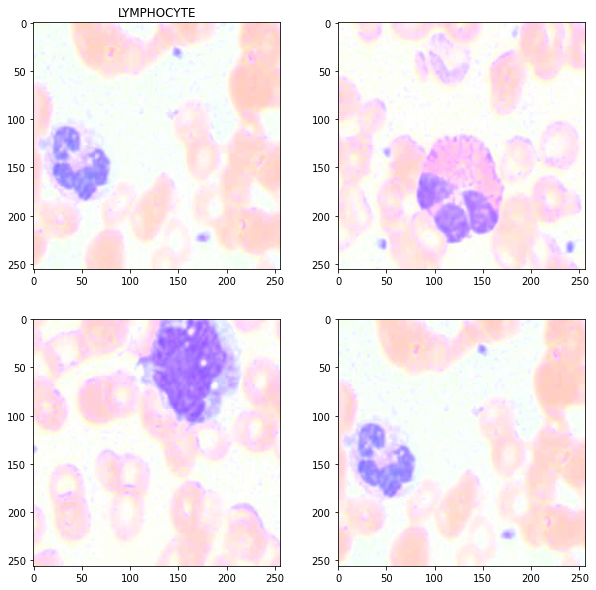

In [26]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].imshow(bnorm_neutrophil_img)
ax[0][0].set_title('NEUTROPHIL')
ax[0][1].imshow(bnorm_esonophil_img)
ax[0][0].set_title('EOSINOPHIL')
ax[1][0].imshow(bnorm_monocyte_img)
ax[0][0].set_title('MONOCYTE')
ax[1][1].imshow(bnorm_lymphocyte_img)
ax[0][0].set_title('LYMPHOCYTE')

Text(0.5, 1.0, 'LYMPHOCYTE')

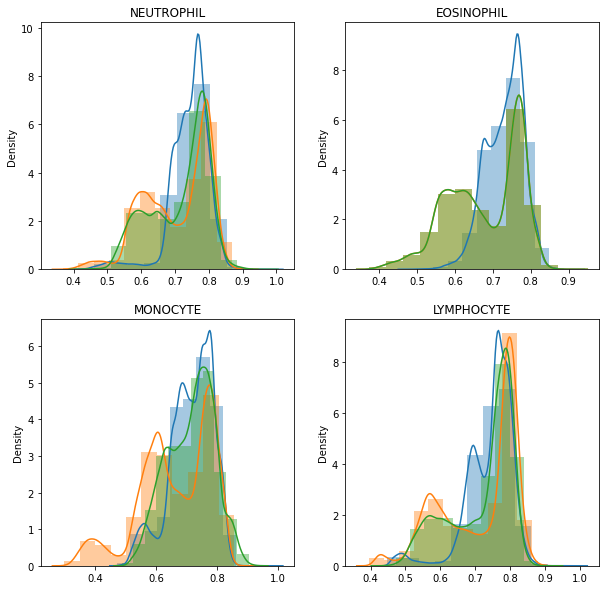

In [27]:
# quick look at color value histograms for pixel matrix from first image
fig, ax = plt.subplots(2,2, figsize=(10,10))

sns.distplot(neutrophil_img_1.matrix[:,0], bins=12,ax=ax[0][0])
sns.distplot(neutrophil_img_1.matrix[:,1], bins=12,ax=ax[0][0])
sns.distplot(neutrophil_img_1.matrix[:,2], bins=12,ax=ax[0][0])
ax[0][0].set_title('NEUTROPHIL')

sns.distplot(esonophil_img_1.matrix[:,0], bins=12,ax=ax[0][1])
sns.distplot(esonophil_img_1.matrix[:,1], bins=12,ax=ax[0][1])
sns.distplot(esonophil_img_1.matrix[:,1], bins=12,ax=ax[0][1])
ax[0][1].set_title('EOSINOPHIL')

sns.distplot(monocyte_img_1.matrix[:,0], bins=12,ax=ax[1][0])
sns.distplot(monocyte_img_1.matrix[:,1], bins=12,ax=ax[1][0])
sns.distplot(monocyte_img_1.matrix[:,2], bins=12,ax=ax[1][0])
ax[1][0].set_title('MONOCYTE')

sns.distplot(lymphocyte_img_1.matrix[:,0], bins=12,ax=ax[1][1])
sns.distplot(lymphocyte_img_1.matrix[:,1], bins=12,ax=ax[1][1])
sns.distplot(lymphocyte_img_1.matrix[:,2], bins=12,ax=ax[1][1])
ax[1][1].set_title('LYMPHOCYTE')

## Edge Detection


<b>Sobel Edge Detection</b>

A Sobel filter is one means of getting a basic edge magnitude/gradient image. Can be useful to threshold and find prominent linear features, etc

In [28]:
import skimage
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import sobel

Text(0.5, 1.0, 'LYMPHOCYTE')

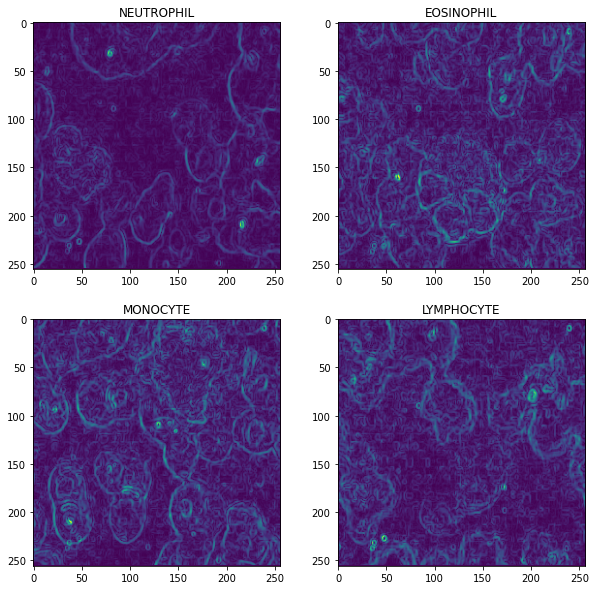

In [29]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].imshow(sobel(neutrophil_img_1.image[:750,:750,2]))
ax[0][0].set_title('NEUTROPHIL')
ax[0][1].imshow(sobel(esonophil_img_1.image[:750,:750,2]))
ax[0][1].set_title('EOSINOPHIL')
ax[1][0].imshow(sobel(monocyte_img_1.image[:750,:750,2]))
ax[1][0].set_title('MONOCYTE')
ax[1][1].imshow(sobel(lymphocyte_img_1.image[:750,:750,2]))
ax[1][1].set_title('LYMPHOCYTE')

Text(0.5, 1.0, 'LYMPHOCYTE')

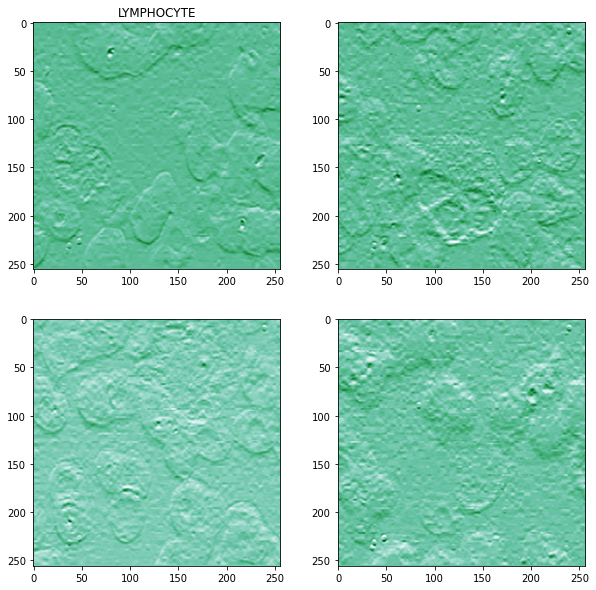

In [30]:
from skimage.filters import sobel_h

fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].imshow(sobel_h(neutrophil_img_1.image[:750,:750,2]),cmap='BuGn')
ax[0][0].set_title('NEUTROPHIL')
ax[0][1].imshow(sobel_h(esonophil_img_1.image[:750,:750,2]),cmap='BuGn')
ax[0][0].set_title('EOSINOPHIL')
ax[1][0].imshow(sobel_h(monocyte_img_1.image[:750,:750,2]),cmap='BuGn')
ax[0][0].set_title('MONOCYTE')
ax[1][1].imshow(sobel_h(lymphocyte_img_1.image[:750,:750,2]),cmap='BuGn')
ax[0][0].set_title('LYMPHOCYTE')

## Single cell

 Lets now use the Annotation to crop the image and do the same analysis for a single cell 

In [31]:
def get_bbox(img):
    """
   Helper function for extracting bounding boxes
    """
    xml = annot_path+img[:-4]+'.xml'
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [32]:
def get_image(img):

    img_path = "dataset-master/JPEGImages/"
    img_filename =img_path+img
    return img_filename

As described above each image can have upto 10 cells . Lets just take one of them for analysis

In [33]:
bbox = get_bbox("BloodImage_00000.xml")
bbox

[(216, 359, 316, 464),
 (77, 326, 177, 431),
 (540, 353, 640, 458),
 (405, 350, 513, 457),
 (160, 72, 245, 177),
 (5, 335, 90, 440),
 (540, 39, 640, 149),
 (383, 1, 504, 113),
 (9, 82, 108, 168),
 (68, 212, 165, 346),
 (171, 181, 264, 282)]

In [34]:
ind_cell = []
neutrophil_i = image_data[image_data["Label"]==dict_characters[1]]["Image_name"].values[1]
ind_cell.append(neutrophil_i)
esonophil_i = image_data[image_data["Label"]==dict_characters[2]]["Image_name"].values[1]
ind_cell.append(esonophil_i )
monocyte_i = image_data[image_data["Label"]==dict_characters[3]]["Image_name"].values[0]
ind_cell.append(monocyte_i)
lymphocyte_i = image_data[image_data["Label"]==dict_characters[4]]["Image_name"].values[0]
ind_cell.append(lymphocyte_i)

In [35]:
neutrophil_i

'BloodImage_00012.jpg'

In [36]:
ind_cell[0]

'BloodImage_00012.jpg'

Lets Plot them

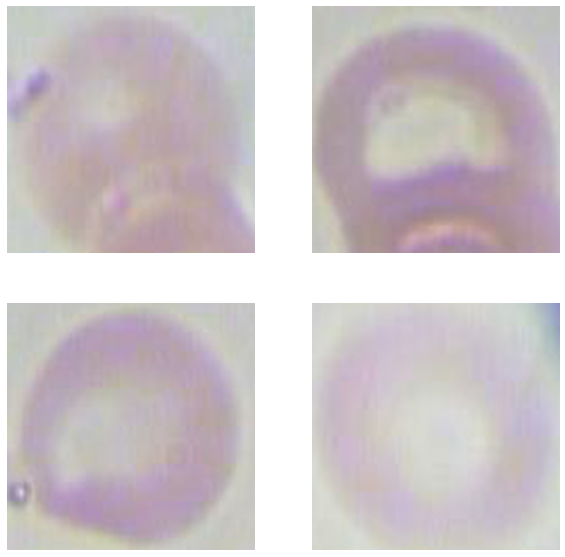

In [37]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

img = []
bbox = get_bbox(ind_cell[0])
cell = get_image(ind_cell[0])
im = Image.open(cell)
for j in range(1):
    im = im.crop(bbox[j])  
    im = im.resize((256,256), Image.ANTIALIAS)  
ax[0][0].axis("off")
ax[0][0].imshow(im)
ax[0][0].set_label(dict_characters[1])
img.append(np.array(im)/255)

bbox = get_bbox(ind_cell[1])
cell = get_image(ind_cell[1])
im = Image.open(cell)
for j in range(1):
    im = im.crop(bbox[j]) 
    im = im.resize((256,256), Image.ANTIALIAS)   
ax[1][0].axis("off")
ax[1][0].imshow(im)
ax[1][0].set_label(dict_characters[2])
img.append(np.array(im)/255)

bbox = get_bbox(ind_cell[2])
cell = get_image(ind_cell[2])
im = Image.open(cell)
for j in range(1):
    im = im.crop(bbox[j]) 
    im = im.resize((256,256), Image.ANTIALIAS)   
ax[0][1].axis("off")
ax[0][1].imshow(im)
ax[0][1].set_label(dict_characters[3])
img.append(np.array(im)/255)

bbox = get_bbox(ind_cell[3])
cell = get_image(ind_cell[3])
im = Image.open(cell)
for j in range(1):
    im = im.crop(bbox[j])
    im = im.resize((256,256), Image.ANTIALIAS)    
ax[1][1].axis("off")
ax[1][1].imshow(im)
ax[1][1].set_label(dict_characters[3])
img.append(np.array(im)/255)

In [38]:
dims = img[0].shape
dims

(256, 256, 3)

In [39]:
img_matrix=[]
for i in img:
  img_matrix.append(np.reshape(i, (dims[0] * dims[1], dims[2])))
img_matrix = np.array(img_matrix)

The variance and mean observation of single cell matches that of the whole image . As we can see Monocyte and Eosinophil has a higher covariance

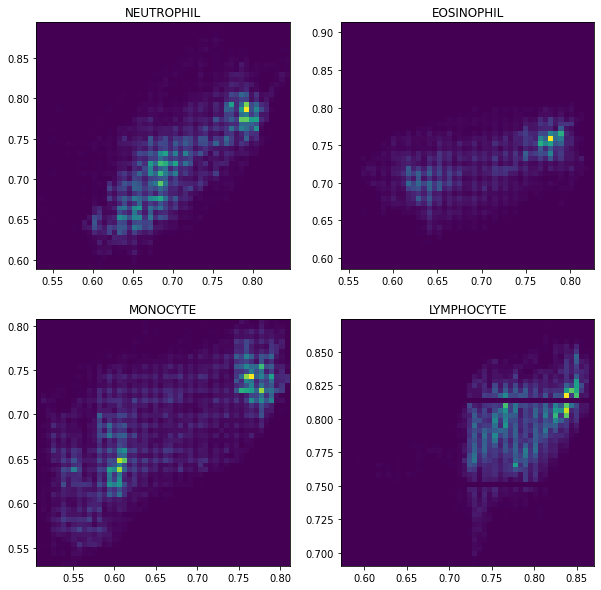

In [40]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
j=[0,0,1,1]
k=[0,1,0,1]
for i in range(img_matrix.shape[0]):
  ax[j[i]][k[i]].hist2d(img_matrix[i][:,1],img_matrix[i][:,2], bins=(50,50))
  ax[j[i]][k[i]].set_title(dict_characters[i+1])

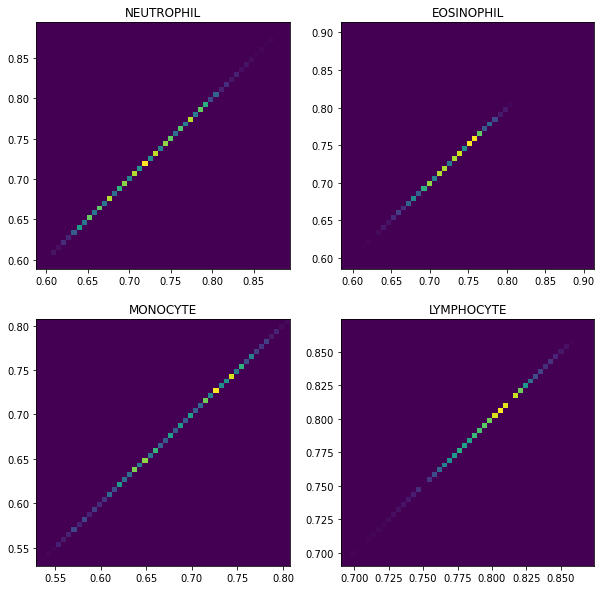

In [41]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
j=[0,0,1,1]
k=[0,1,0,1]
for i in range(img_matrix.shape[0]):
  ax[j[i]][k[i]].hist2d(img_matrix[i][:,2],img_matrix[i][:,2], bins=(50,50))
  ax[j[i]][k[i]].set_title(dict_characters[i+1])

This observation also matches that of whole image.

<b> So we can say these some what defines the property of each cell that can be used as features for classification </b>

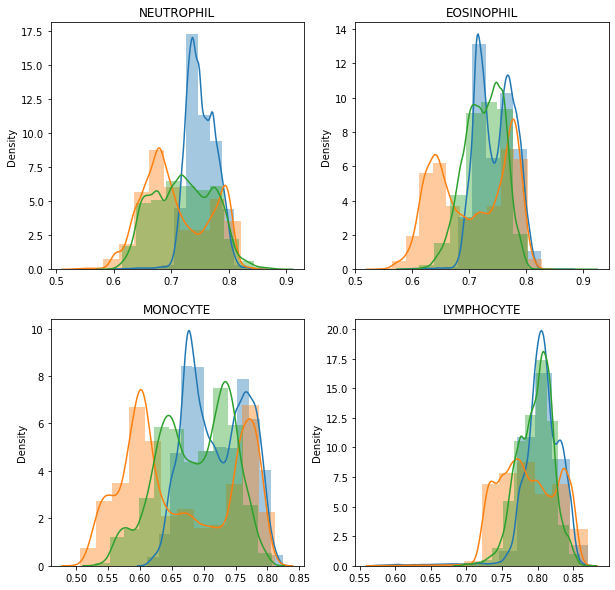

In [42]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
j=[0,0,1,1]
k=[0,1,0,1]
for i in range(img_matrix.shape[0]):
  sns.distplot(img_matrix[i][:,0], bins=12,ax=ax[j[i]][k[i]])
  sns.distplot(img_matrix[i][:,1], bins=12,ax=ax[j[i]][k[i]])
  sns.distplot(img_matrix[i][:,2], bins=12,ax=ax[j[i]][k[i]])
  ax[j[i]][k[i]].set_title(dict_characters[i+1])

## Channels 

Lets take a look to different channels of each cell

<b>Observation </b>

Loking at the channels and images its clear that

1 Neutrophil has a smaller white blob and is dense at that point

2 While eosinophile has a larger blob but is not too dense

3 Monocyte has the largest bolb of all and is easier to identify

4 Lymphocyte has a large blob compared to neutrophile but the density is too low and is difficult to see.

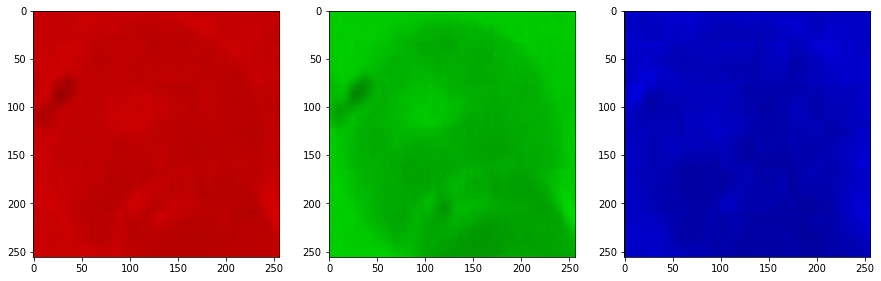

In [43]:
fig,ax=plt.subplots(1,3,figsize=(15,5)) 

for c,ax in zip(range(3),ax): 
  split_img=img[0].copy()
  for i in range(3):
    if(i!=c):
      split_img[:,:,i] =0
  #print(img[0])
  ax.imshow(split_img)
  #break

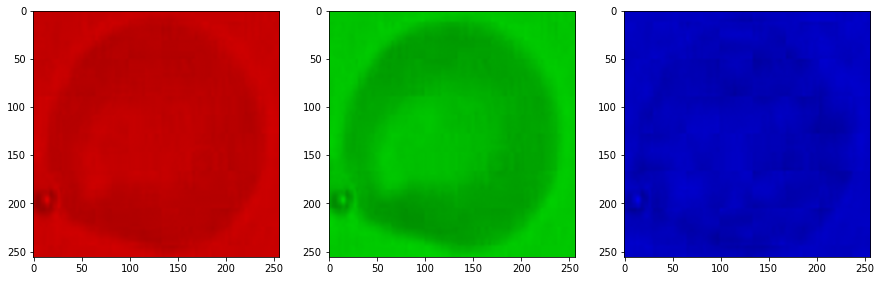

In [44]:
fig,ax=plt.subplots(1,3,figsize=(15,5)) 

for c,ax in zip(range(3),ax): 
  split_img=img[1].copy()
  for i in range(3):
    if(i!=c):
      split_img[:,:,i] =0
  #print(img[0])
  ax.imshow(split_img)
  #break

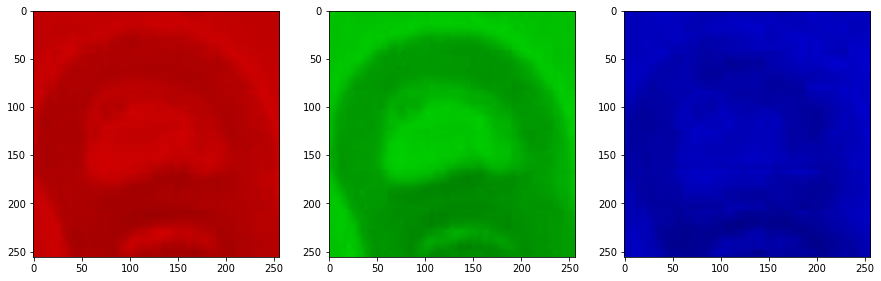

In [45]:
fig,ax=plt.subplots(1,3,figsize=(15,5)) 

for c,ax in zip(range(3),ax): 
  split_img=img[2].copy()
  for i in range(3):
    if(i!=c):
      split_img[:,:,i] =0
  #print(img[0])
  ax.imshow(split_img)
  #break

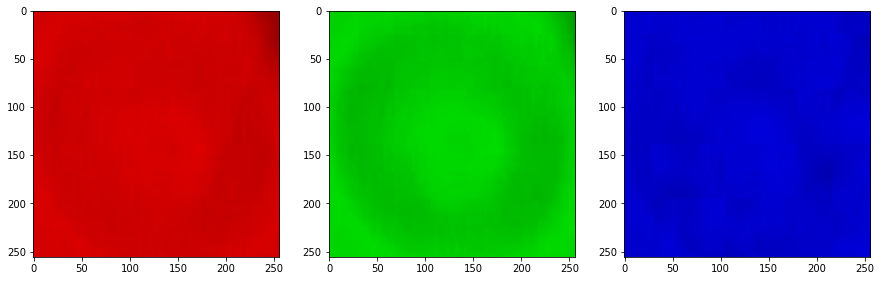

In [46]:
fig,ax=plt.subplots(1,3,figsize=(15,5)) 

for c,ax in zip(range(3),ax): 
  split_img=img[3].copy()
  for i in range(3):
    if(i!=c):
      split_img[:,:,i] =0
  #print(img[0])
  ax.imshow(split_img)
  #break

<b> Final Observation</b>

In our over all analysis of variance spread and covariance it seema that it all depends on the bolb of each cell. And this will help in any classification

 Factors that can be used to differentiate are:
 
 1 Size of blob

 2 Density

 3 Spread

## Model Training and Prediction

In [47]:
!pip install livelossplot==0.5.2
import livelossplot
print("Livelossplot version:", livelossplot.__version__)

Livelossplot version: 0.5.2


In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models


from IPython.display import SVG, Image
#from livelossplot import PlotLossesTensorFlowKeras
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


In [82]:
train_path = "dataset2-master/images/TRAIN"
test_path = "dataset2-master/images/TEST_SIMPLE"
val_path = "dataset2-master/images/TEST"

In [83]:
##### For tarining set
datagen = ImageDataGenerator(
        rescale=1./255
)
#### for validation set 
datagen_valid = ImageDataGenerator(rescale=1./255)

datagen_test = ImageDataGenerator(rescale=1./255)

In [209]:
batch_size = 32

In [210]:
train_generator = datagen.flow_from_directory(train_path,
                                               seed=0,
                                              target_size= (128,128),
                                               batch_size=batch_size,
                                               shuffle=True,
                                               class_mode='categorical')

Found 9976 images belonging to 4 classes.


In [211]:
validation_generator = datagen_valid.flow_from_directory(val_path,
                                               seed=123,
                                             target_size= (128,128),
                                             class_mode='categorical'
                                                           )

Found 2487 images belonging to 4 classes.


In [212]:
test_generator = datagen_valid.flow_from_directory(test_path,
                                               seed=0,
                                             target_size= (128,128),
                                             class_mode='categorical'
                                                           )

Found 71 images belonging to 4 classes.


In [217]:
model = Sequential()

# 1- conv
model.add(Conv2D(128,(3,3),padding='same',input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

# 2- conv layer
model.add(Conv2D(64,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))


# 3- conv Layer
model.add(Conv2D(32,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

 #4- conv layer
model.add(Conv2D(16,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

# Flatting layer
model.add(Flatten())

model.add(Dense(4,activation= 'softmax'))

initial_learning_rate = 0.001


opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization_80 (Batc (None, 128, 128, 128)     512       
_________________________________________________________________
activation_92 (Activation)   (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 64, 64, 64)        204864    
_________________________________________________________________
batch_normalization_81 (Batc (None, 64, 64, 64)      

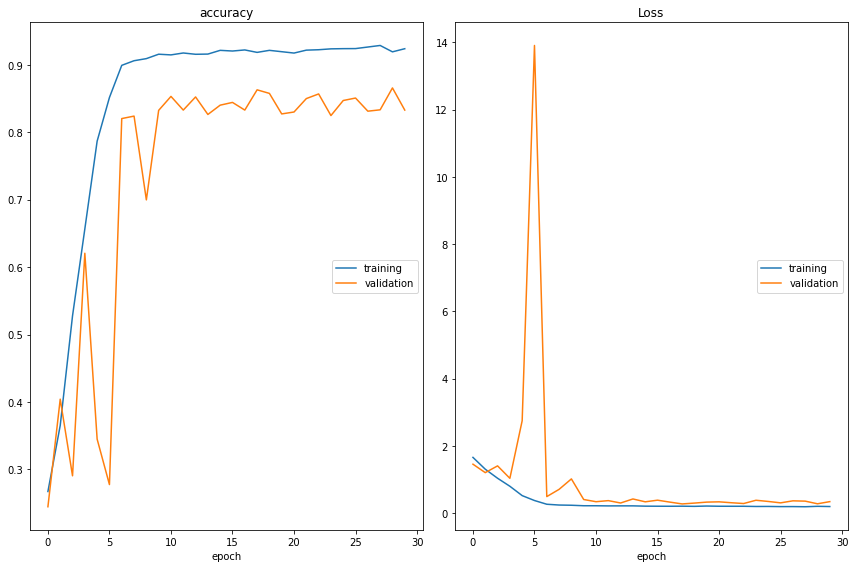

accuracy
	training         	 (min:    0.267, max:    0.929, cur:    0.924)
	validation       	 (min:    0.245, max:    0.866, cur:    0.833)
Loss
	training         	 (min:    0.192, max:    1.659, cur:    0.198)
	validation       	 (min:    0.275, max:   13.906, cur:    0.343)

Epoch 00030: saving model to model_final_weights.h5


In [218]:
epochs = 30
steps_per_epoch = train_generator.n//batch_size
validation_steps = validation_generator.n//batch_size

# Callback to save best weights
checkpoint = ModelCheckpoint("model_final_weights.h5",monitor='val_accuracy',
                            save_weights_only = True,mode='max',verbose=1) # Only saving weights

reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=2,
                             min_lr=0.00001,mode='auto')# Reduce learning rate is validation loss doesn't reduce

callbacks = [PlotLossesKeras(),checkpoint,reduce_lr]


history = model.fit(
    train_generator ,        
          validation_data=validation_generator,
    epochs=epochs,
   steps_per_epoch=steps_per_epoch ,
    validation_steps= validation_steps,
    verbose=1,
    callbacks=callbacks)

In [219]:
model.evaluate(test_generator)

3/3 [==============================] - 21s 11s/step - loss: 0.4166 - accuracy: 0.8169


[0.4166295826435089, 0.8169013857841492]